In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
directory = r'/content/drive/MyDrive/MyWork/6-МНК/DATASET'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [4]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


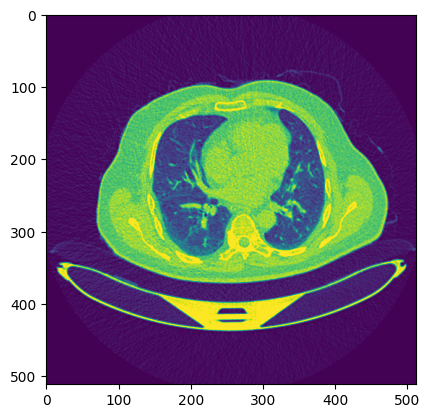

Malignant cases


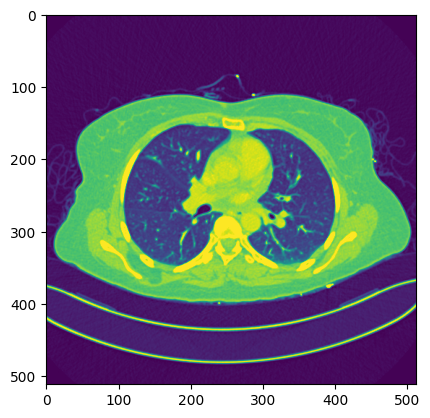

Normal cases


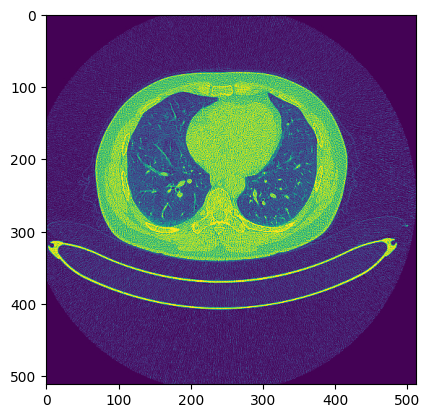

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

In [6]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


In [9]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 424, 2: 308, 0: 90}) Counter({1: 137, 2: 108, 0: 30})


In [10]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [11]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 424, 2: 308, 0: 90})
After SMOTE: Counter({0: 424, 1: 424, 2: 424})


In [12]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1272 (1272, 256, 256, 1)


In [13]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

In [ ]:
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])
resnet_base.summary()

In [16]:
from keras.utils import plot_model

In [17]:
# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

model = Sequential()

model.add(resnet_base)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40359171 (153.96 MB)
Trainable params: 16777731 (64.00 MB)
Non-trainable params: 23581440 (89.96 MB)
_________________________________________________________________


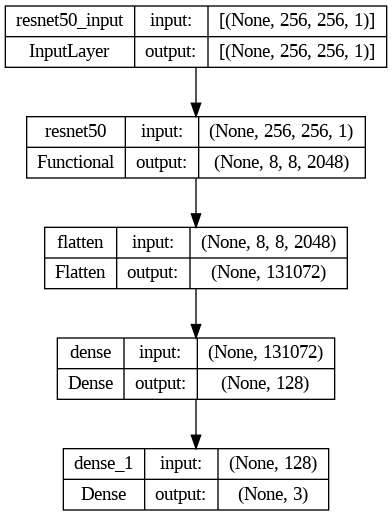

In [18]:
plot_model(model, to_file='model_resnet_basel_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
103/103 [==============================] - 331s 3s/step - loss: 0.8186 - accuracy: 0.6290 - val_loss: 0.7624 - val_accuracy: 0.6327
Epoch 2/20
103/103 [==============================] - 318s 3s/step - loss: 0.7259 - accuracy: 0.7165 - val_loss: 0.5790 - val_accuracy: 0.7818
Epoch 3/20
103/103 [==============================] - 320s 3s/step - loss: 0.4854 - accuracy: 0.8090 - val_loss: 0.4203 - val_accuracy: 0.9236
Epoch 4/20
103/103 [==============================] - 316s 3s/step - loss: 0.3446 - accuracy: 0.8893 - val_loss: 0.4446 - val_accuracy: 0.8436
Epoch 5/20
103/103 [==============================] - 315s 3s/step - loss: 0.2885 - accuracy: 0.9088 - val_loss: 0.2548 - val_accuracy: 0.9273
Epoch 6/20
103/103 [==============================] - 313s 3s/step - loss: 0.2903 - accuracy: 0.9100 - val_loss: 0.2490 - val_accuracy: 0.9091
Epoch 7/20
103/103 [==============================] - 314s 3s/step - loss: 0.1815 - accuracy: 0.9526 - val_loss: 0.1774 - val_accuracy: 0.9418

In [22]:
model.save('ResNet50.keras')

In [23]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 104s 11s/step
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.99      1.00      1.00       137
           2       0.94      0.99      0.96       108

    accuracy                           0.97       275
   macro avg       0.98      0.92      0.94       275
weighted avg       0.97      0.97      0.97       275

[[ 23   0   7]
 [  0 137   0]
 [  0   1 107]]


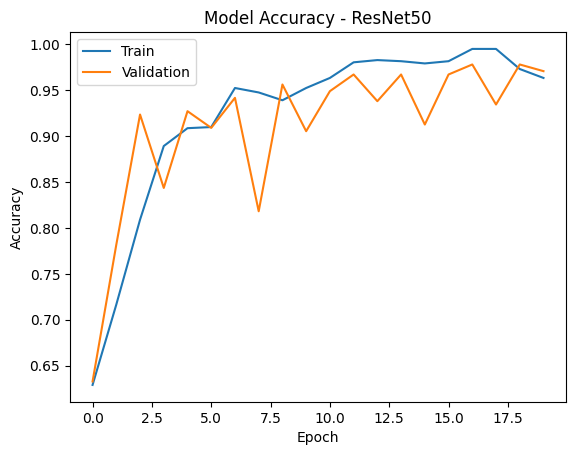

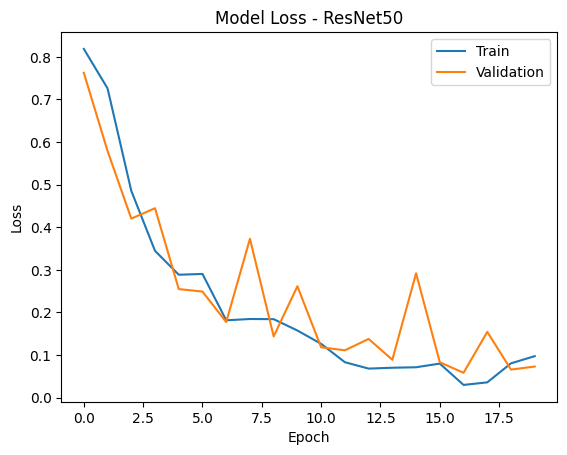

In [24]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss - ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [27]:
history.history['val_accuracy']

[0.6327272653579712,
 0.7818182110786438,
 0.9236363768577576,
 0.8436363339424133,
 0.9272727370262146,
 0.9090909361839294,
 0.9418181777000427,
 0.8181818127632141,
 0.9563636183738708,
 0.9054545164108276,
 0.9490908980369568,
 0.9672726988792419,
 0.9381818175315857,
 0.9672726988792419,
 0.9127272963523865,
 0.9672726988792419,
 0.9781818389892578,
 0.9345454573631287,
 0.9781818389892578,
 0.9709091186523438]

In [26]:
history.history['val_loss']

[0.7624306678771973,
 0.5789868831634521,
 0.4202587604522705,
 0.44464796781539917,
 0.254848837852478,
 0.24896806478500366,
 0.17738541960716248,
 0.37289729714393616,
 0.1436876505613327,
 0.26151254773139954,
 0.11815299093723297,
 0.11110371351242065,
 0.13778521120548248,
 0.08890016376972198,
 0.29186567664146423,
 0.08302151411771774,
 0.05827512592077255,
 0.15428341925144196,
 0.06587868928909302,
 0.07300823926925659]